In [1]:
%matplotlib inline
from Bio import motifs
import matplotlib.pyplot as plt
from math import log
import scipy as sp
import numpy as np
import csv
import matplotlib.gridspec as gridspec

from pylab import setp
plt.rcParams['figure.figsize'] = (15.0, 10.0)


In [3]:
## Read motifs
motifs_all = motifs.parse(open('test_meme_data/test/meme_analysis/meme.txt'), 'meme')
motif1, motif2, motif3 = motifs_all

In [4]:
## Read images
logo1 = plt.imread('test_meme_data/test/meme_analysis/logo1.png')
logo2 = plt.imread('test_meme_data/test/meme_analysis/logo2.png')
logo3 = plt.imread('test_meme_data/test/meme_analysis/logo3.png')


In [5]:
##Check plot sizes
logo1.shape

(294, 904, 4)

In [6]:
logo2.shape


(294, 668, 4)

In [7]:
logo3.shape

(294, 786, 4)

'212' represents the logo height which is constant as expected.
We model the logo width as the logo width using a linear fit:

$$
Width = a+B*N_{motifs}
$$

where,

$a$: Represents the white margins to the left and right of the sequence logo


$B$: Represents the width occupied by individual bse logo(assume all bases take the same width)


$N_{motifs}$: Represent the number of motifs


In [8]:
logo_widths = [x.shape[1] for x in [logo1,logo2,logo3]]
logo_widths

[904, 668, 786]

In [9]:
n_motifs = [len(x) for x in motifs_all]
n_motifs

[21, 15, 18]

In [11]:
## Fit linear model

Z = sp.polyfit(n_motifs, logo_widths,1)


a = Z[0]
b = Z[1]
Z

array([ 39.33333333,  78.        ])

In [12]:
##inches
# a={'26':11.01, '21':9.04, '29':11.81}

Z_inches = sp.polyfit(n_motifs, [9.04, 11.01, 11.81] ,1)
P_inches = sp.poly1d(Z_inches)
P_inches(21)

9.6350000000000016

In [13]:
Z_inches


array([ -0.32833333,  16.53      ])

In [14]:
## Check if it does what it should
P = sp.poly1d(Z)
### Should be close to 651
P(21)

904.0

In [15]:
## Should be close to 793
P(26)


1100.6666666666667

In [16]:
## Should be close to 850
#P(29)
logo2.shape[1]-(40+15+25.5*(a+3.3))

-474.14999999999964

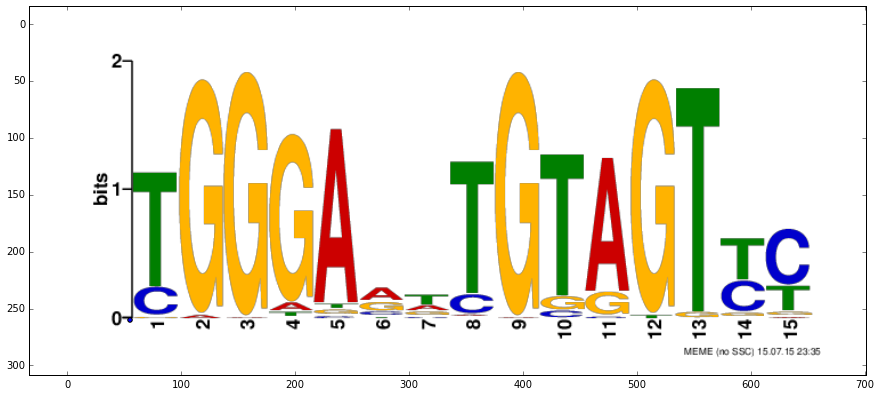

78.00000000000027

In [24]:
## By trial and error try plotting a dot on the [0,0] of logo
implot = plt.imshow(logo2)
#plt.scatter([40],[185])
#plt.scatter([40+23*a],[185])
plt.scatter([40+15],[260])

plt.show()
b

In [20]:
## Calculate bits for motif 1:
motif1_bits = []
bases = ['A','T','G','C']
for i in range(0, len(motif1)):
    s = 0
    for base in bases:
        s = s+ -motif1.pwm[base][i]*log(motif1.pwm[base][i],2) if motif1.pwm[base][i]!=0 else s
    s=2-s
    motif1_bits.append(s)

In [21]:
## Smoke test: should be high for 5th position where 'A' occurs in the logo and close to 2 bits

motif1_bits

[0.0849816853511931,
 0.061374209682245606,
 0.6759394003649266,
 0.6299234550735469,
 1.8178615354211336,
 1.9765381446223094,
 1.6268264311988012,
 1.1807824433085723,
 1.8560542889923102,
 1.1865915660047337,
 0.3414232841105984,
 0.2493889318633773,
 1.3270207009209474,
 1.7134206279751865,
 2.0,
 1.9245893045912685,
 1.1648272414484802,
 0.7877390695482211,
 0.293892256138538,
 0.9266250438873853,
 0.40797564814311515]

In [22]:
## Plot a blue dot using the linear fit for each position corresponding to the total information at that position
X = [40+15] ## this is by trial and error, the position for the first base logo
## Generate all other X coordinates
for j in range(1,21):
    X.append(X[j-1]+a+3.3)
    
## Y coordinates:

## 1 bit along the Y axis = 80 pixels
Y = [212-80*x-27 for x in motif1_bits]


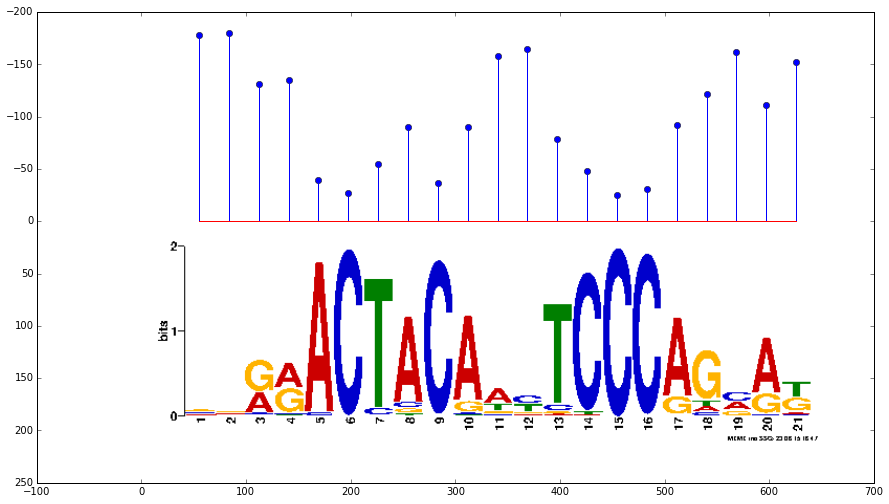

In [23]:
implot = plt.imshow(logo1)
plt.stem(X,[-y for y in Y])
plt.show()

ValueError: x and y must have same first dimension

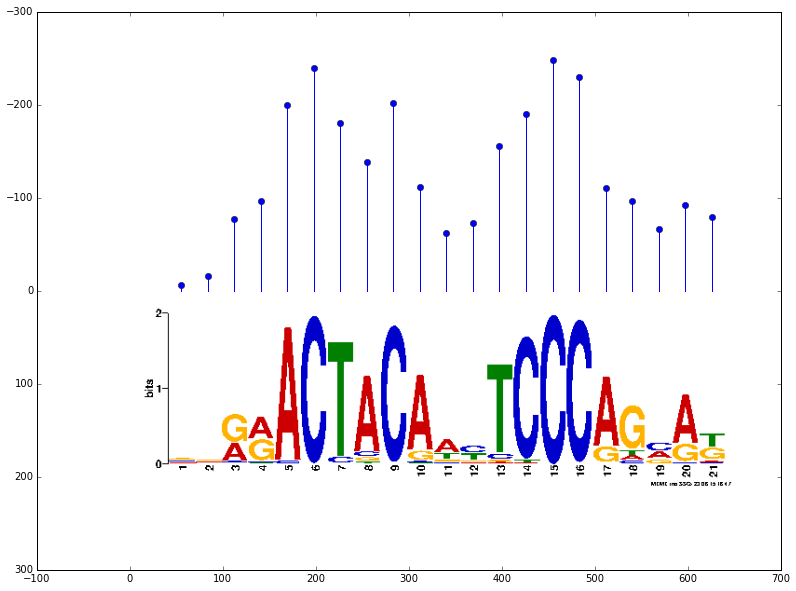

In [24]:
def position_wise_profile(counts_dict, length):
    profile = map(dict, zip(*[[(k, v) for v in value] for k, value in counts_dict.items()]))
    return profile

def find_max_occurence(profile, max_count=2):
    sorted_profile = []
    for p in profile:
        sorted_profile.append(sorted(p.items(), key=lambda x:x[1]))
    for i,p in enumerate(sorted_profile):
        sorted_profile[i] = p[-max_count:]
    return sorted_profile

def formatter(x):
    return "2^{0}".format(x)

score_type = 'pssm'

handle = open('test_meme_data/meme.txt')
records = motifs.parse(handle, 'meme')
record = records[1]
motif_scores = []
profile = position_wise_profile(getattr(record, score_type), record.length)
max_occur = find_max_occurence(profile, max_count=1)
motif_scores = []
for position in max_occur:
    motif_scores.append(position[0][1])

sample_phylo_scores = []
control_phylo_scores = []
sample_phylo_data = csv.reader(open('test_meme_data/sample.stats','r'), delimiter='\t')
control_phylo_data = csv.reader(open('test_meme_data/control.stats','r'), delimiter='\t')
for line in control_phylo_data:
        control_phylo_scores.append(float(line[1]))
for line in sample_phylo_data:
        sample_phylo_scores.append(float(line[1]))
flanking_sites = 10
sample_phylo_scores = np.array(sample_phylo_scores)
control_phylo_scores = np.array(control_phylo_scores)
motif_junk = [0 for i in range(0, flanking_sites)]
motif_junk = np.array(motif_junk)
motif_concat = np.concatenate((motif_junk, motif_scores))
motif_concat = np.concatenate((motif_concat, motif_junk))
motif1_bits = []
motif1=record
for i in range(0, len(motif2)):
    s = 0
    for base in bases:
        s = s+ -motif1.pwm[base][i]*log(motif1.pwm[base][i],2) if motif1.pwm[base][i]!=0 else s
    s=2-s
    motif1_bits.append(s)

Y = [-80*x-48 for x in sample_phylo_scores[flanking_sites:-flanking_sites]]
M = [-80*x for x in motif1_bits]

fig = plt.figure()
ax = fig.add_subplot(111)
implot = ax.imshow(logo1)
#plt.stem(X,[-y for y in Y])
plt.stem(X, [y for y in Y],   basefmt=' ', linefmt='b-')
plt.stem(X, [y for y in M],   basefmt=' ', linefmt='b-', markerfmt='ro')
plt.legend(['PhyloP Conservation', 'Motif Count'])
#plt.show()
plt.xlim(xmin=40)
plt.xticks([])
plt.yticks([-240-24,-161-24,-80-24,0, 24,212-27], [2.5,2,1,0,2,1])
plt.savefig('combined-plot.png')

In [25]:
from matplotlib.font_manager import FontProperties



ax.set_title('axes title')
font = FontProperties()
font.set_family('monospace')
ax.set_xlabel('xlabel')
ax.set_ylabel('ylabel')
ax.text(3,8, 'A', fontsize='50', fontproperties=font, fontname='Sans', color='red')
ax.axis([0, 10, 0, 10])

plt.show()


In [26]:
80.5-24

56.5

In [27]:
base_wise_informat
for i in range(0, len(motif1)):
    s = 0
    for base in bases:
        s = s+ -motif1.pwm[base][i]*log(motif1.pwm[base][i],2) if motif1.pwm[base][i]!=0 else s
    s=2-s
    motif1_bits.append(s)

NameError: name 'base_wise_informat' is not defined

In [28]:

    fig = plt.figure()

    ax = fig.add_subplot(2,2,1)
    implot = ax.imshow(logo1)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.axes = 'off'
    #ax.set_axes('off')
    ax.set_frame_on(False)

    #plt.stem(X,[-y for y in Y])
    #plt.subplots_adjust(top=0.5,hspace=0.00000001, wspace=0.00001)



    X = [40+25] ## this is by trial and error, the position for the first base logo
    ## Generate all other X coordinates
    for j in range(1,21+2*flanking_sites):
        X.append(X[j-1]+a+10)
    motif_junk = [0 for i in range(0, flanking_sites)]
    motif_junk = np.array(motif_junk)
    motif_concat = np.concatenate((motif_junk, motif1_bits))
    motif_concat = np.concatenate((motif_concat, motif_junk))

    Y = [80.0*x for x in sample_phylo_scores]#[flanking_sites:-flanking_sites]]
    M = [80.0*x for x in motif_concat]#[flanking_sites:-flanking_sites]]

    plt.subplots_adjust(top=0.5,hspace=0.00000001, wspace=0.00001)
    ax2 = fig.add_subplot(2,2,3)
    #ax2.stem(X, [y for y in Y],   basefmt=' ', linefmt='g-')
    #ax2.stem(X, [y for y in M],   basefmt=' ', linefmt='b-', markerfmt='ro')
    ax2.plot(X, [y for y in M], marker='o',color='0.65',linestyle='-', linewidth=2)
    ax2.fill_between(X, [y for y in M], color='0.80')

    ax2.plot(X, [y for y in Y], marker='o',color='g',linestyle='-', linewidth=2)
    #ax2.legend(['PhyloP Conservation', 'Motif Count'])
    #plt.show()
    #plt.xlim(xmin=40)
    ax2.set_yticks([min(Y), np.mean(Y), max(Y)])
    ax2.set_yticklabels([min(Y)/80.0, np.mean(Y)/80.0, max(Y)/80.0])
    ax2.set_xticks(X)
    ax2.set_xticklabels([i for i in range(1,22+2*flanking_sites)])
    ax2.set_frame_on(False)
    plt.savefig('update-plot.png')
    #plt.xticks([])
    #plt.yticks([-240-24,-161-24,-80-24,0, 24,212-27], [2.5,2,1,0,2,1])

IndentationError: unexpected indent (<ipython-input-28-4425bcfe6378>, line 2)

NameError: name 'a_between' is not defined

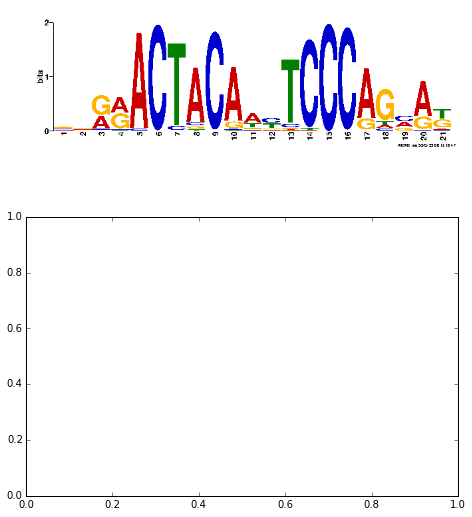

In [29]:

#fig = plt.figure()
#plt.subplots_adjust(top=0.5,hspace=0.00000001, wspace=0.00001)
plt.axis('tight')
ax = plt.subplot2grid((2,2),(0, 0), colspan=2)

ax.imshow(logo1)
ax.set_xticks([])
ax.set_yticks([])
#ax.axes = 'off'
#ax.set_axes('off')
ax.set_frame_on(False)

#plt.stem(X,[-y for y in Y])
#plt.subplots_adjust(top=0.5,hspace=0.00000001, wspace=0.00001)



X = [40+25] ## this is by trial and error, the position for the first base logo
## Generate all other X coordinates
for j in range(1,21):#+2*flanking_sites):
    X.append(X[j-1]+a+10)
motif_junk = [0 for i in range(0, flanking_sites)]
motif_junk = np.array(motif_junk)
motif_concat = np.concatenate((motif_junk, motif1_bits))
motif_concat = np.concatenate((motif_concat, motif_junk))

Y = [80.0*x for x in sample_phylo_scores[flanking_sites:-flanking_sites]]
M = [80.0*x for x in motif_concat[flanking_sites:-flanking_sites]]

plt.subplots_adjust(left=0.5,hspace=0.00000001, wspace=0.00001)
ax2 = plt.subplot2grid((2,2),(1, 0), colspan=2)

#fig.add_subplot(2,2,3)
#ax2.stem(X, [y for y in Y],   basefmt=' ', linefmt='g-')
#ax2.stem(X, [y for y in M],   basefmt=' ', linefmt='b-', markerfmt='ro')
a_between(X, [y for y in M], color='0.80')

ax2.plot(X, [y for y in Y], marker='o',color='g',linestyle='-', linewidth=2)
#ax2.legend(['PhyloP Conservation', 'Motif Count'])
#plt.show()x2.plot(X, [y for y in M], marker='o',color='0.65',linestyle='-', linewidth=2)
ax2.fill
#plt.xlim(xmin=40)
ax2.set_yticks([min(Y), np.mean(Y), max(Y)])
ax2.set_yticklabels([min(Y)/80.0, np.mean(Y)/80.0, max(Y)/80.0])
ax2.set_xticks(X)
ax2.set_xticklabels([i for i in range(1,22+2*flanking_sites)])
ax2.set_frame_on(False)
plt.savefig('update-plot.png')
#plt.xticks([])
#plt.yticks([-240-24,-161-24,-80-24,0, 24,212-27], [2.5,2,1,0,2,1])

In [146]:
min(Y)

-41.433759999999999

In [168]:
a

25.234693877550956

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import sys
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import statsmodels.api as sm
from Bio import motifs
from pylab import savefig
import ntpath
import os
from math import log
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties


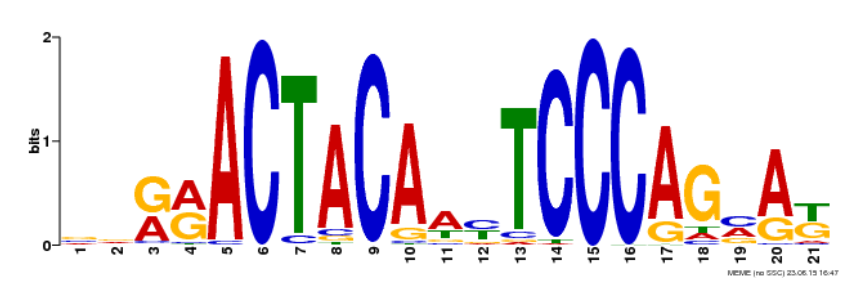

In [141]:
motif_no = 1
handle = open('test_meme_data/meme.txt')
records = motifs.parse(handle, 'meme')
record = records[motif_no-1]
num_occurrences = getattr(record,'num_occurrences','Unknown')
sample_phylo_data = csv.reader(open('test_meme_data/100way_phyloP.flanking10.txt.stats','r'), delimiter='\t')
control_phylo_data = csv.reader(open('test_meme_data/control.stats','r'), delimiter='\t')
sample_gerp_data = csv.reader(open('test_meme_data/RS_score.flanking10.txt.stats','r'), delimiter='\t')
control_gerp_data = csv.reader(open('test_meme_data/RS_score_random.flanking10.txt.stats','r'), delimiter='\t')
sample_phylo_scores = []
flanking_sites = 10
for line in sample_phylo_data:
    sample_phylo_scores.append(float(line[1]))
control_phylo_scores = []
for line in control_phylo_data:
    control_phylo_scores.append(float(line[1]))

sample_gerp_scores = []
for line in sample_gerp_data:
    sample_gerp_scores.append(float(line[1]))
control_gerp_scores = []
for line in control_gerp_data:
    control_gerp_scores.append(float(line[1]))

assert (len(sample_phylo_scores) == len(control_phylo_scores))

profile = position_wise_profile(getattr(record, score_type), record.length)
max_occur = find_max_occurence(profile, max_count=1)
motif_scores = []
for position in max_occur:
    motif_scores.append(position[0][1])


motif_scores = np.array(motif_scores)
sample_phylo_scores = np.array(sample_phylo_scores)
control_phylo_scores = np.array(control_phylo_scores)
sample_gerp_scores = np.array(sample_gerp_scores)
control_gerp_scores = np.array(control_gerp_scores)

motif_junk = [0 for i in range(0, flanking_sites)]
motif_junk = np.array(motif_junk)
motif_concat = np.concatenate((motif_junk, motif_scores))
motif_concat = np.concatenate((motif_concat, motif_junk))


if flanking_sites>0:
    pr_p = pearsonr(motif_scores, sample_phylo_scores[flanking_sites:-flanking_sites])
    pr_control_p = pearsonr(motif_scores, control_phylo_scores[flanking_sites:-flanking_sites])
    pr_g = pearsonr(motif_scores, sample_phylo_scores[flanking_sites:-flanking_sites])
    pr_control_g = pearsonr(motif_scores, control_phylo_scores[flanking_sites:-flanking_sites])
else:
    pr_p = pearsonr(motif_scores, sample_phylo_scores)
    pr_control_p = pearsonr(motif_scores, control_phylo_scores)
    pr_g = pearsonr(motif_scores, sample_phylo_scores)
    pr_control_g = pearsonr(motif_scores, control_phylo_scores)
T_p, p_p = stats.ttest_ind(sample_phylo_scores[flanking_sites:-flanking_sites], control_phylo_scores[flanking_sites:-flanking_sites])
T_g, p_g = stats.ttest_ind(sample_gerp_scores[flanking_sites:-flanking_sites], control_gerp_scores[flanking_sites:-flanking_sites])
t_test = ''
if p_g/2<0.01:
    t_test += 'Rejected H0'
else:
    t_test += 'Cannot reject H0'

t_test += '\n1-tailed p-value: {}'.format(p_g/2)

pr_flanking = pearsonr(motif_concat, sample_phylo_scores)

pr_control_flanking = pearsonr(motif_concat, control_phylo_scores)


ms_p = np.mean(np.concatenate((sample_phylo_scores[0:flanking_sites], sample_phylo_scores[-flanking_sites:])))
mc_p = np.mean(np.concatenate((control_phylo_scores[0:flanking_sites], control_phylo_scores[-flanking_sites:])))
ms_g = np.mean(np.concatenate((sample_gerp_scores[0:flanking_sites], sample_gerp_scores[-flanking_sites:])))
mc_g = np.mean(np.concatenate((control_gerp_scores[0:flanking_sites], control_gerp_scores[-flanking_sites:])))

if flanking_sites>0:
    shifted_sample_phylo_scores = sample_phylo_scores[flanking_sites:-flanking_sites]-ms_p
    shifted_control_phylo_scores = control_phylo_scores[flanking_sites:-flanking_sites]-mc_p
    shifted_sample_gerp_scores = sample_gerp_scores[flanking_sites:-flanking_sites]-ms_g
    shifted_control_gerp_scores = control_gerp_scores[flanking_sites:-flanking_sites]-mc_g
else:
    shifted_sample_phylo_scores = sample_phylo_scores
    shifted_control_phylo_scores = control_phylo_scores
    shifted_sample_gerp_scores = sample_gerp_scores
    shifted_control_gerp_scores = control_gerp_scores

reg_phylop_sample = sm.OLS(shifted_sample_phylo_scores,sm.add_constant(motif_scores)).fit()
y_reg_phylop_sample = motif_scores*reg_phylop_sample.params[1]+reg_phylop_sample.params[0]

reg_phylop_control = sm.OLS(shifted_control_phylo_scores,sm.add_constant(motif_scores)).fit()
y_reg_phylop_control = motif_scores*reg_phylop_control.params[1]+reg_phylop_control.params[0]

reg_gerp_sample = sm.OLS(shifted_sample_gerp_scores,sm.add_constant(motif_scores)).fit()
y_reg_gerp_sample = motif_scores*reg_gerp_sample.params[1]+reg_gerp_sample.params[0]

reg_gerp_control = sm.OLS(shifted_control_gerp_scores,sm.add_constant(motif_scores)).fit()
y_reg_gerp_control = motif_scores*reg_gerp_control.params[1]+reg_gerp_control.params[0]

#title = 'Near Peak pearsonr = {}, p-val={}\nRandom Region pearsonr={}, p-val={} \n Motif n_occur={}\n '.format(pr[0],pr[1], pr_control[0], pr_control[1], num_occurrences)
#title += t_test
motif = record
motif_length = motif.length
meme_dir = os.path.dirname('test_meme_data/meme.txt')
X = [40+15] ## this is by trial and error, the position for the first base logo
## Generate all other X coordinates
#left_margin = 40
#right_margin = logo.shape[1]-(40+15+(motif_length-0.5)*(a+3.3))
gs =  gridspec.GridSpec(2, 1)
logo = plt.imread(os.path.join(meme_dir, 'logo{}.png'.format(motif_no)))
#gs.update(left=0.05, right=0.48, wspace=0.025, hspace=0.05, top=0.5, bottom=0.09)
#gs.update(wspace=0, hspace=0)
f = plt.figure(figsize=(15,15), dpi=900, facecolor='w', edgecolor='k')

#ax = plt.Subplot(f, gs[0,:])
ax = f.add_subplot(211)
ax.imshow(logo, extent=[40+15+3*(a+3.3),logo.shape[1]+15+4.5*(a+3.3),0,212])
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
#f.add_subplot(ax)

fs = min(flanking_sites, 5)
#for j in range(1,5):
#    t = X[j-1]+8
#    X.append(t)
for j in range(1,len(motif)+2*fs):
    t = X[j-1]+(a+3.3)
    X.append(t)
#for j in range(len(motif)+fs+1,len(motif)+2*fs):
#    t = X[j-1]+8
#    X.append(t)
    
motif_bits = []
for i in range(0, motif.length):
    s = 0
    for base in bases:
        s = s + -motif.pwm[base][i]*log(motif.pwm[base][i], 2) if motif.pwm[base][i]!=0 else s
        s = 2-s
    motif_bits.append(s)
y_phylop_pixels = [80.0*x for x in sample_phylo_scores[fs:-fs]]#[flanking_sites:-flanking_sites]]
y_motif_pixels = [80.0*x for x in motif_bits]


In [142]:
Z_inches = [0.35112245,  1.72489796]
#gs =  gridspec.GridSpec(2, 2)
#ax2 = plt.Subplot(f, gs[1,:])
ax2 = f.add_subplot(212, sharex=ax)
#ax2 = plt.subplot(gs[1, 0])#, colspan=1)
#ax2.plot(motif_scores, [y for y in y_motif_pixels], marker='o',color='0.65',linestyle='-', linewidth=2)
#ax2.fill_between(motif_scores, [y for y in y_motif_pixels], color='0.80')
#ax2.plot(motif_scores, [y for y in y_phylop_pixels], marker='o',color='g',linestyle='-', linewidth=2)
markerline, stemlines, baseline  = ax2.stem(X[:fs], [y for y in y_phylop_pixels[:fs]], markerfmt="_", linefmt="-", markerfacecolor='0.55', color='0.55')
setp(stemlines, 'color', '0.55')
setp(markerline, 'markerfacecolor', '0.55')
setp(markerline, 'color', '0.55')
ax2.stem(X[fs:-fs], [y for y in y_phylop_pixels[fs:-fs]], markerfmt="g_", linefmt="g-", basefmt="r-")
markerline, stemlines, baseline  =  ax2.stem(X[-fs:], [y for y in y_phylop_pixels[-fs:]], markerfmt="_", linefmt="-", markerfacecolor='0.55', color='0.55')
setp(stemlines, 'color', '0.55')
setp(markerline, 'markerfacecolor', '0.55')
ax2.set_yticks([min(y_phylop_pixels), np.mean(y_phylop_pixels), max(y_phylop_pixels)])
ax2.set_yticklabels(["%0.2f"%(min(y_phylop_pixels)/80.0), "%0.2f"%(np.mean(y_phylop_pixels)/80.0), "%0.2f"%(max(y_phylop_pixels)/80.0)])
indices = np.arange(-fs, len(X)-fs, 1)
indices_str=[]
for i in indices:
    if i<0:
        indices_str.append('{}'.format(i))
    elif i>=0 and i<motif_length:
        indices_str.append('{}'.format(i+1))
    else:
        indices_str.append('+{}'.format(i-motif_length+1))
print indices
xticks = [X[i+fs] for i in indices]
ax2.set_xticks(xticks)#[X[0], X[len(X)//2], X[len(X)-1]])
ax2.set_xticklabels(indices_str)# indices)#[1, len(X)//2,len(X)])
ax2.set_xlabel('Base Position')
ax2.set_ylabel('PhyloP Score')
ax2.set_xlim([0,(motif_length+2*fs)*(a+3.3)+3*a])
#ax2.set_frame_on(False)
#f.add_subplot(ax2)
#savefig('separate_trend.eps', format='eps')#, format='svg', dpi=120)


[-5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 24 25]


(0, 960.27959183673261)

In [143]:
f.savefig('basic.png')

In [ ]:
ax.set_